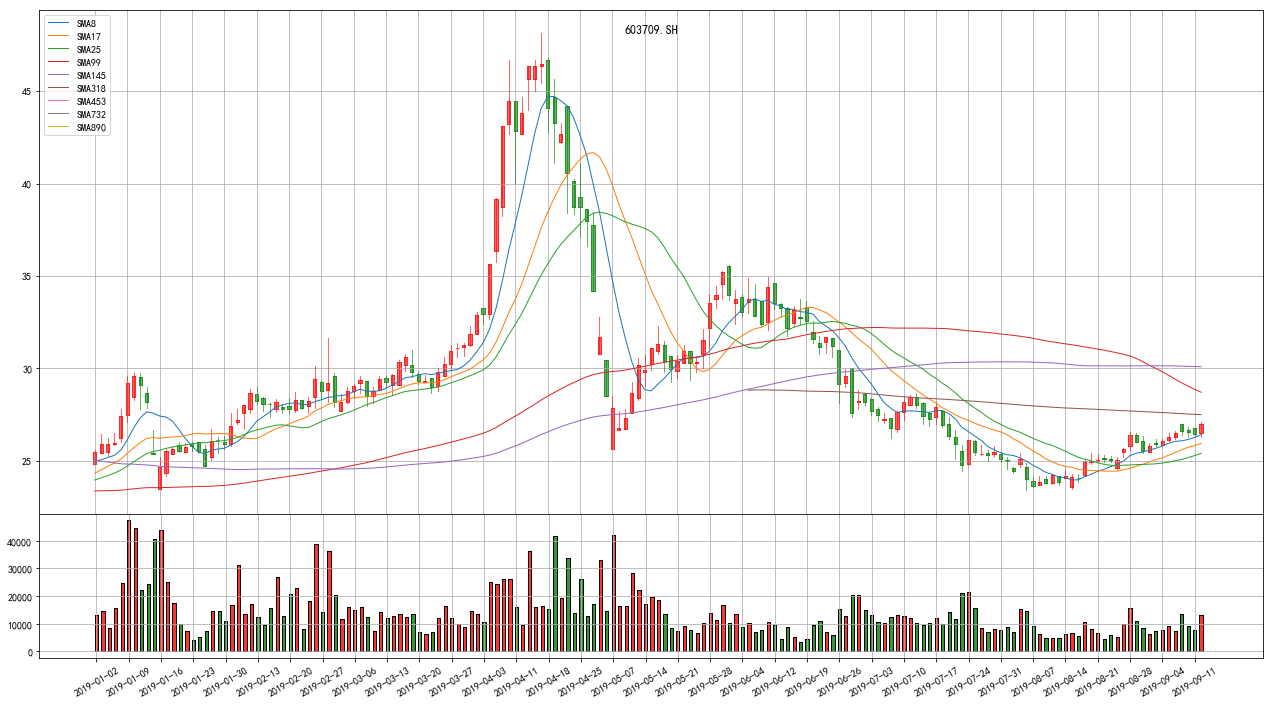

In [21]:
%matplotlib inline
import mysqlx
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import mpl_finance as mpf
import talib

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

tsCode ='603709.SH'
startDate = '2019-01-01'
fixSmas = [
    '8'
    ,'17'
    ,'25'
    ,'99'
    ,'145'
    ,'318'
    ,'453'
    ,'732'
    ,'890'
]

connection_string = {
    'host': 'localhost',
    'port': 33160,
    'user': 'stock',
    'password': 'aRmbZH9dx9k6TzRB'
}
client_options = {
    'pooling': {
        "max_size": 10,
        "max_idle_time": 30000
    }
}
client = mysqlx.get_client(connection_string, client_options)


session = client.get_session()
schemaList = session.get_schemas()

schema = session.get_schema('stock')

#get split daily
col = schema.get_collection('stock_x_split_adjusted_daily')
docs = col.find("tsCode = :tscode AND tradeDate >=:trade_date " ).bind('tscode',tsCode).bind('trade_date',startDate).sort('tradeDate').execute()
dailyDatas = docs.fetch_all()

col = schema.get_collection('stock_x_tec_sma')

# get fix smas
smaDatas = {};
for period in fixSmas:     # 第一个实例
    tecName = 'Sma'+period
    smaDocs = col.find("tsCode = :tscode AND tradeDate >=:trade_date AND tecName = :tec_name ").bind('tscode',tsCode).bind('trade_date',startDate).bind('tec_name',tecName).execute();
    datas = smaDocs.fetch_all()
    for data in datas:
        if not hasattr(data, 'value'):
            setattr(data,'value', np.nan)
    smaDatas[period] = datas




session.close()
client.close()

variables = dailyDatas[0].keys()
df = pd.DataFrame([[getattr(i,j) for j in variables] for i in dailyDatas], columns = variables)

smaDic = {}

for key in smaDatas:
    variables = ['value','tradeDate','tsCode','tecName'];
    tmp_df = pd.DataFrame([[getattr(i,j) for j in variables] for i in smaDatas[key]], columns = variables)
    smaDic[key] = tmp_df


fig = plt.figure(figsize=(17, 10))
fig.suptitle(tsCode)
ax = fig.add_axes([ 0 , 0.3 ,1 ,0.7])
ax2 = fig.add_axes([ 0 , 0.1 , 1 ,0.2])

# ax = fig.add_subplot(1, 1, 1)

# ax.set_xticks(range(0, len(df['tradeDate']), 10))
ax.set_xticks(range(0, len(df['tradeDate']), 5))
# ax.set_xticklabels(df['tradeDate'].str.slice(start=0,stop=10)[::5],rotation=30)

for key in smaDic:
    ax.plot(smaDic[key]['value'],label = 'SMA'+key,linewidth=1)
ax.legend(loc='upper left')
ax.grid(True)

mpf.candlestick2_ochl(ax, df['open'], df['close'], df['high'], df['low'],
                     width=0.5, colorup='r', colordown='green',
                     alpha=0.6)

mpf.volume_overlay(ax2, df['open'], df['close'], df['vol'], colorup='r', colordown='g', width=0.5, alpha=0.8)
ax2.set_xticks(range(0, len(df['tradeDate']), 5))
ax2.set_xticklabels(df['tradeDate'].str.slice(start=0,stop=10)[::5],rotation=30)
ax2.grid(True)



# plt.subplots_adjust(hspace=0)

# axes = df.plot.line(y=['close','open'],x='tradeDate')



plt.show()
# plt.subplots_adjust(hspace=0)

# axes = df.plot.line(y=['close','open'],x='tradeDate')

